# Project Proposal

## Safety First - Hard Hat Detection

### Team Member

- Stanley Yang
- Lennard Vanderspek 
 
### Description

Workplace safety is very important but often overlooked. Most important way to keep workers 
safe is by wearing a hard hat. This project will utilize Convolution Neural Net and YOLO to help 
detect whether workers are wearing a hard hat or not.

#### Machine Learning Topics Used:

- Convolution Neural Net 
- YOLO 
 
### Expected Outcome

A trained model that is able to detect whether workers are wearing a hard hat or not by 
implementing YOLO using PyTorch. We are hoping to utilize the model to bring more awareness 
to workplace safety.

---

# Use CUDA if Available

In [1]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
# Load the Data


## Create Custom Dataset Class

In [2]:
from torch.utils.data import Dataset
import cv2
import torchvision.transforms as transforms
import os

def yolo_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, labels  # keep labels as list of [N_i, 5] tensors

class customDataset(Dataset):
    def __init__(self, image_path, label_path, transform:transforms = None):
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform

        # Load images and labels
        self.images = sorted(os.listdir(image_path))
        self.labels = sorted(os.listdir(label_path))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        label_name = self.labels[index]

        # Load the image
        image = cv2.imread(os.path.join(self.image_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        # Load the label
        labels = []
        with open(os.path.join(self.label_path, label_name), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Skipping invalid label line: {line.strip()}")
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                labels.append([class_id, x_center, y_center, width, height])

        return image, torch.tensor(labels, dtype=torch.float32)

## Load the Data using Custom Dataset Class

In [3]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# specify the image classes
classes = ['head', 'helmet', 'person']

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((416, 416))
    ])

# load the data set
train_data = customDataset(
    image_path='data-yolo-v7/train/images',
    label_path='data-yolo-v7/train/labels',
    transform=transform
)
test_data = customDataset(
    image_path='data-yolo-v7/test/images',
    label_path='data-yolo-v7/test/labels',
    transform=transform
)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers, collate_fn=yolo_collate_fn)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers, collate_fn=yolo_collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, collate_fn=yolo_collate_fn)

## Visualize a Batch of Training Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.9604645e-08..1.0].


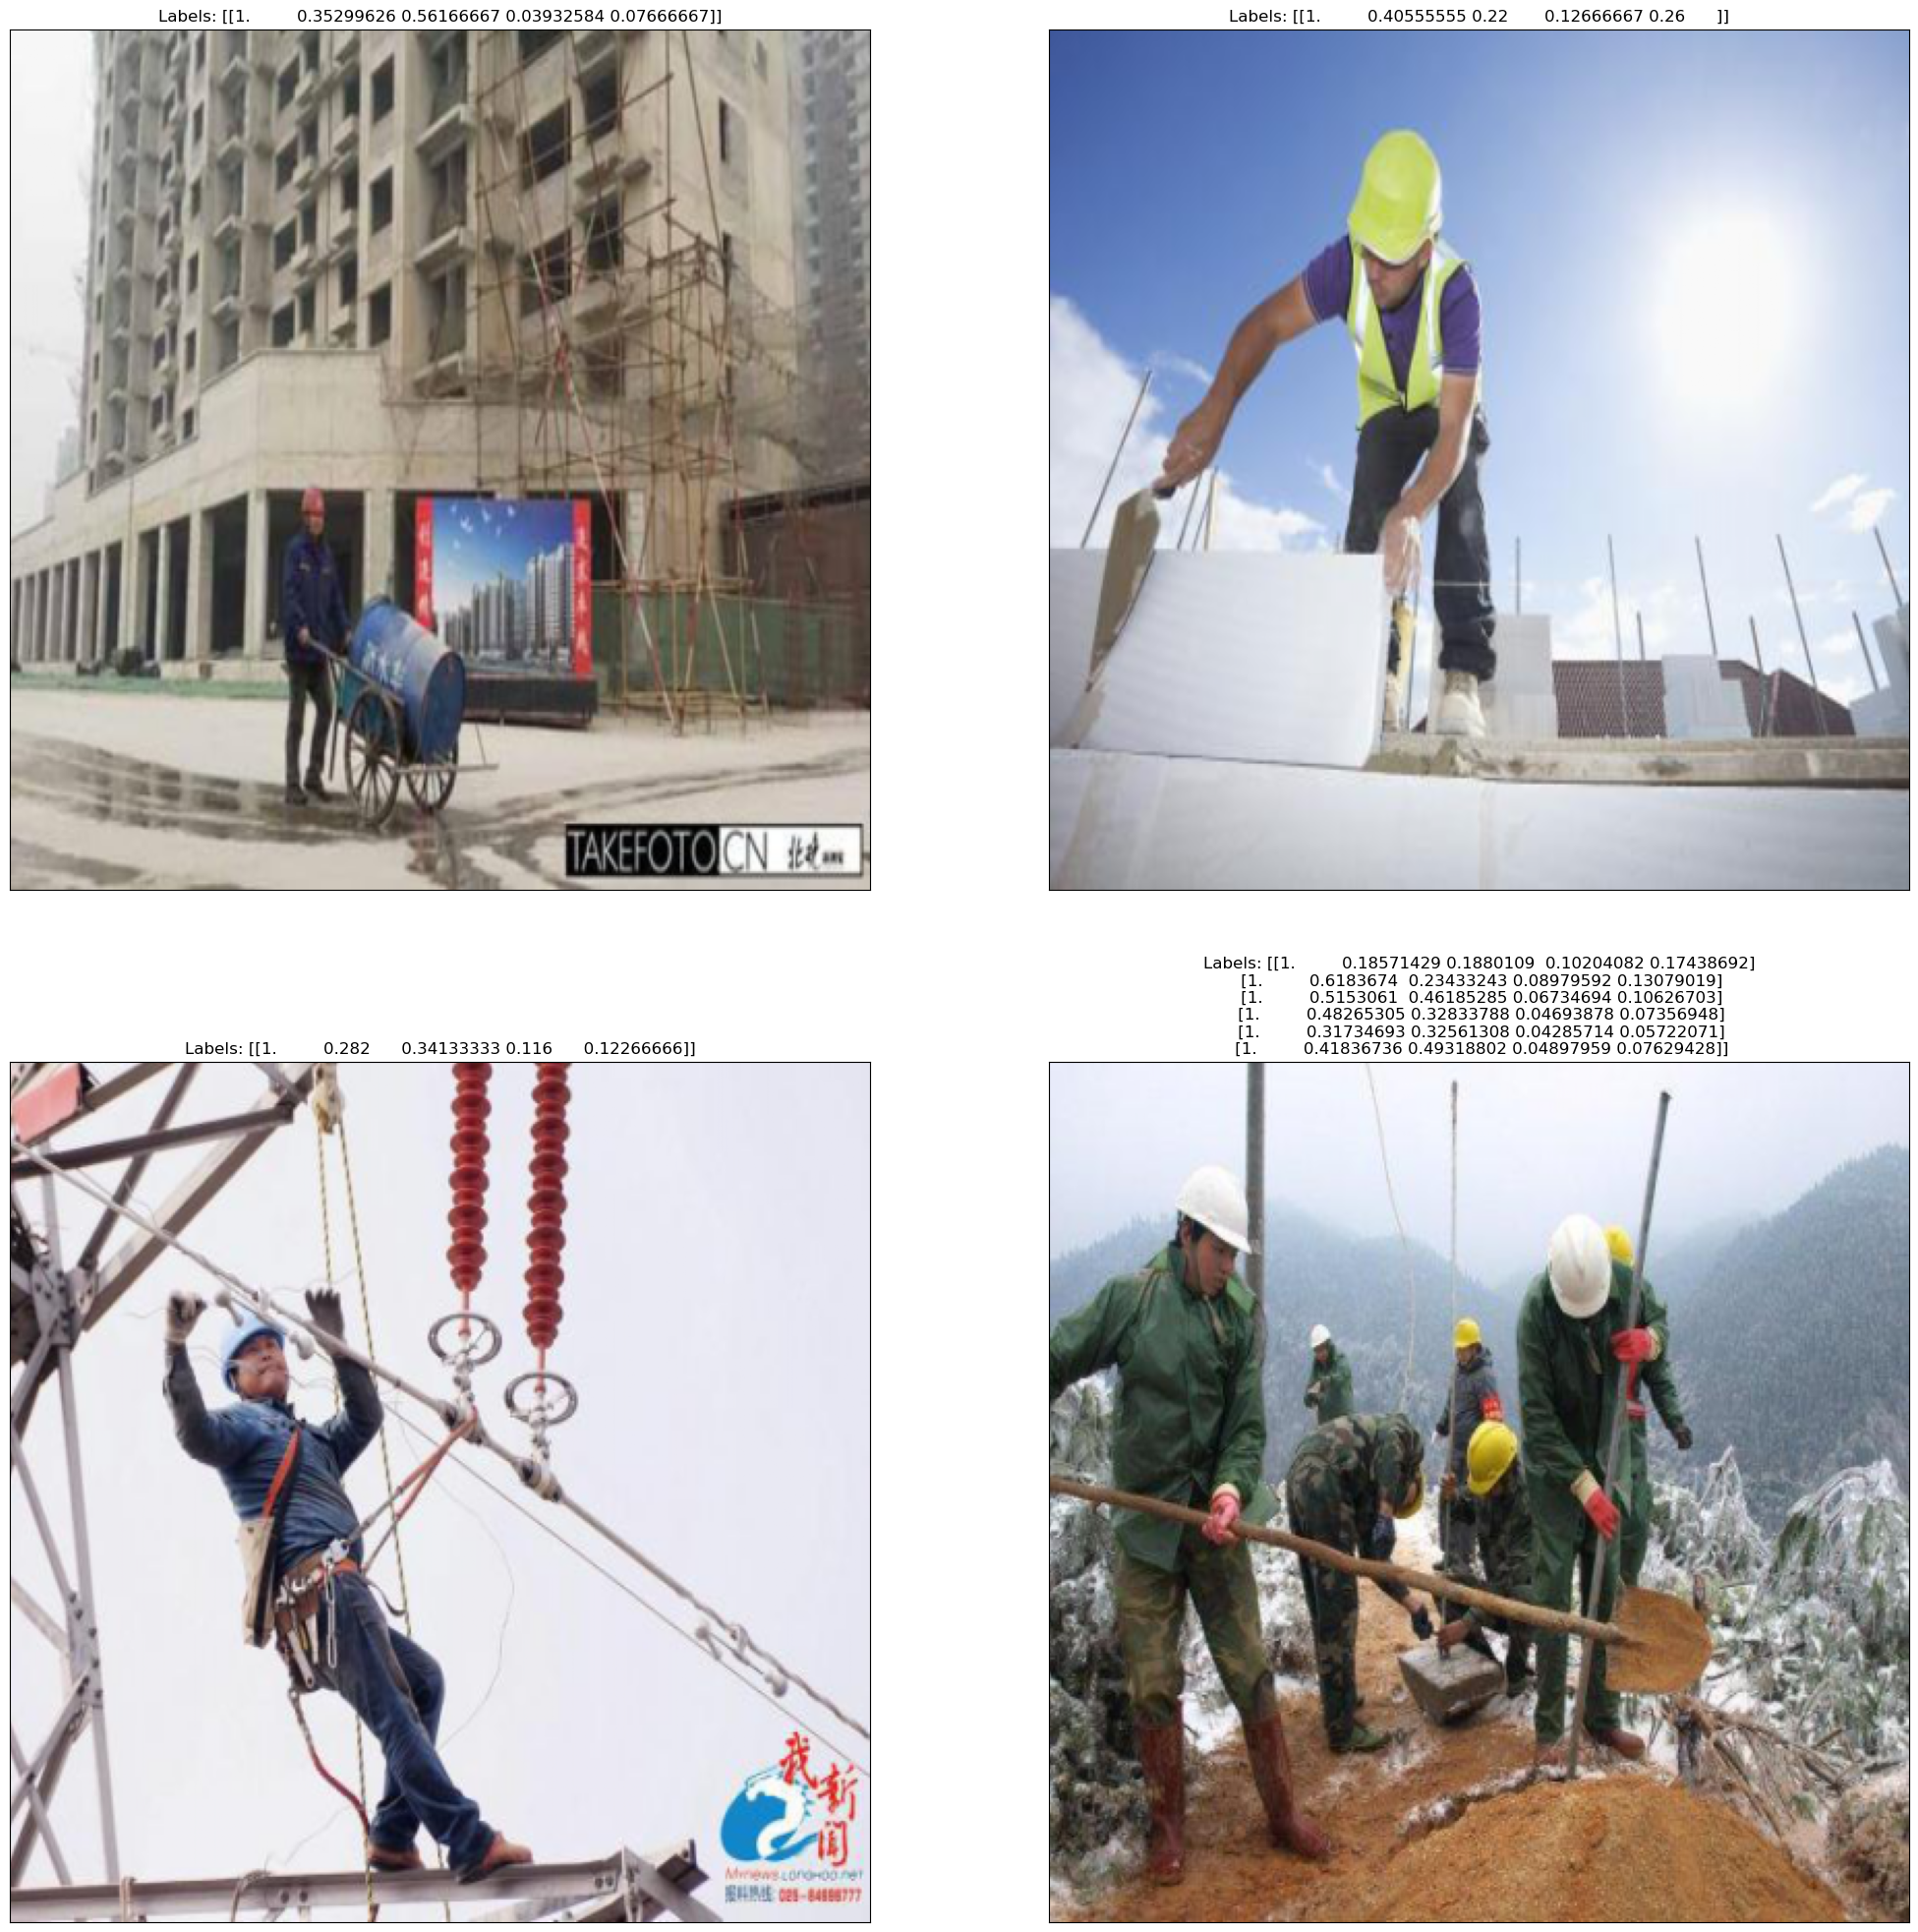

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 25))

# display 2 images
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # get the corresponding labels
    label = labels[idx].numpy()
    # display the labels
    ax.set_title(f'Labels: {label}')  # show class_id, x_center, y_center, width, height